In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2

import sys, os
from monai.losses import DiceCELoss
from pathlib import Path
import torch

# insert the project root (one level up from this folder) onto sys.path
ROOT = Path(os.getcwd()).parent.resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
    
from src.inference.inference import run_inference, evaluate, ensemble_inference
from src.utils.visualization import visualize_slices

/home/herminea/.local/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2025-04-28 08:50:00.382652: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 08:50:00.405788: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available

In [11]:
exp = "exp25_nnunet"
fold = "fold1"
preds = ROOT / "results" / exp / fold / "predictions"

DATA_DIR       = "/datasets/tdt4265/mic/open/HNTS-MRG"
CHECKPOINT     = ROOT / "results" / exp / fold / "checkpoints/best.ckpt"
OUTPUT_DIR     = ROOT / "results" / exp /"inference" / "single_model"
BATCH_SIZE     = 1
MODEL_TYPE     = "nnunet"
DEVICE         = torch.device("cuda:0")  

In [12]:
loss_fn = DiceCELoss(
    to_onehot_y=True, softmax=True,
    lambda_dice=0.5, lambda_ce=0.5
)

In [13]:
# Single model
model, loader = run_inference(DATA_DIR, CHECKPOINT, OUTPUT_DIR, BATCH_SIZE, MODEL_TYPE, DEVICE)
metrics = evaluate(model, loader, loss_fn, DEVICE)
# print the metrics
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

Inference: 100%|██████████| 20/20 [00:01<00:00, 15.46it/s]


Inference done; outputs in /home/herminea/tdt4265_mini_project/results/exp25_nnunet/inference/single_model


Evaluation: 100%|██████████| 20/20 [00:00<00:00, 34.05it/s]

avg_loss: 0.1782
mean_dice: 0.7040
dice_class1: 0.8802
dice_class2: 0.5277
prec_class1: 0.7114
recall_class1: 0.6808
prec_class2: 0.7512
recall_class2: 0.6309


In [9]:
# Ensemble
CKPT_GLOB = str(ROOT / "results" / exp / "fold*" / "checkpoints" / "best.ckpt")
OUT_ENS   = ROOT / "results" / exp / "inference" / "ensemble"

# run inference and grab model + loader
models, loader = ensemble_inference(DATA_DIR, OUT_ENS, CKPT_GLOB, MODEL_TYPE, BATCH_SIZE, DEVICE)
metrics_ens = evaluate(models, loader, loss_fn, DEVICE)
# print the metrics
for key, value in metrics_ens.items():
    print(f"{key}: {value:.4f}")

Ensemble Inference: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Ensembled predictions saved to /home/herminea/tdt4265_mini_project/results/exp25_nnunet/inference/ensemble


Evaluation: 100%|██████████| 20/20 [00:01<00:00, 14.47it/s]

avg_loss: 0.1797
mean_dice: 0.7210
dice_class1: 0.8874
dice_class2: 0.5547
prec_class1: 0.7180
recall_class1: 0.6630
prec_class2: 0.7533
recall_class2: 0.5879


Label class distribution: (1747406, 5418, 16648)
Prediction class distribution: (1744998, 5544, 18930)


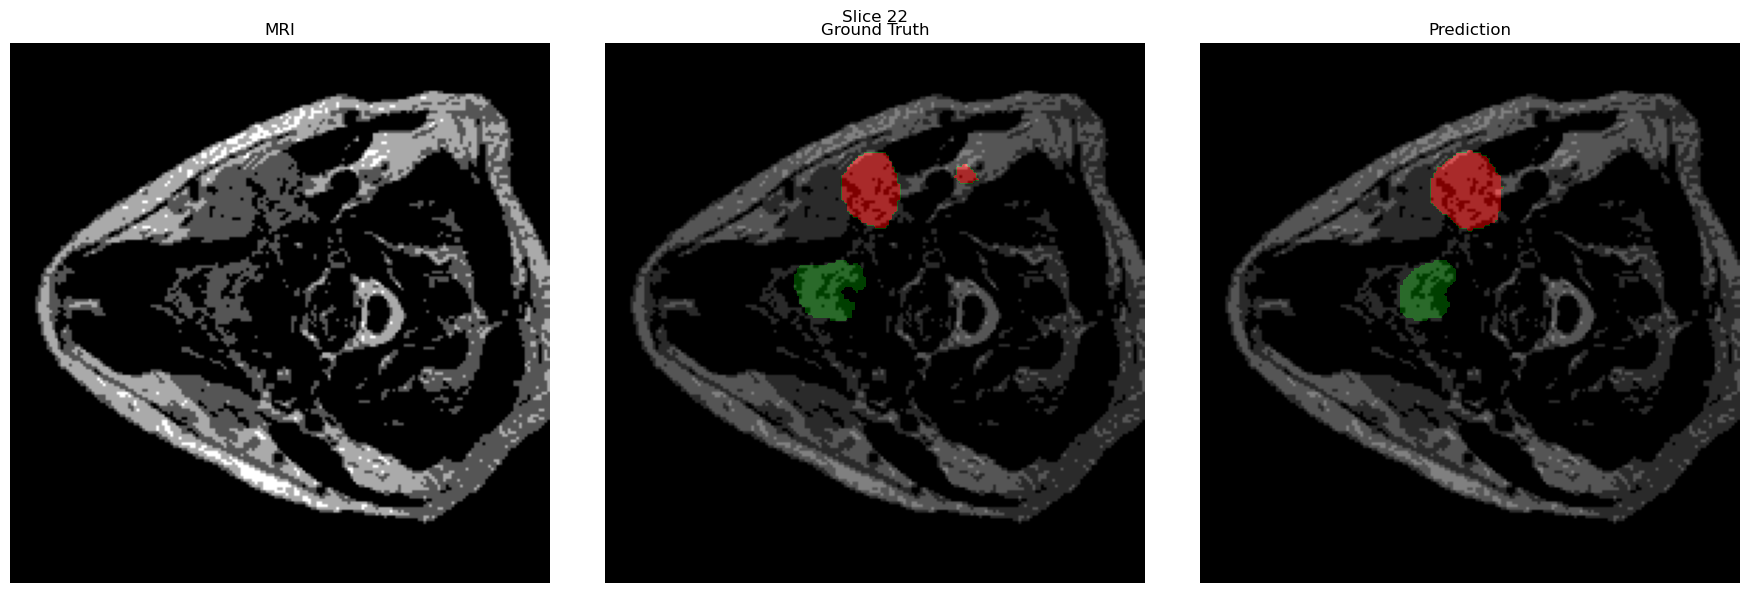

In [32]:
# Visualize
visualize_slices(f"{OUTPUT_DIR}/image_9.nii.gz",
                 f"{OUTPUT_DIR}/label_9.nii.gz",
                 f"{OUTPUT_DIR}/prediction_9.nii.gz", slice_idx=22)
